## Notebook Overview: Clustering U.S. Counties by Weather Patterns

This notebook identifies latent weather exposure profiles across U.S. counties and segments them into meaningful climate risk clusters. Using a combination of engineered weather indicators, factor analysis, and clustering methods, the workflow captures both short-term extremes and long-term climate trends.

Key steps include:

- Loading, cleaning, and standardizing 3-year rolling weather metrics
- Removing outliers at the state level to preserve regional comparability
- Extracting latent weather traits through factor analysis with varimax rotation
- Running K-Means clustering on latent dimensions plus rural-urban classification
- Assigning interpretable labels to clusters and visualizing patterns spatially
- Consolidating detailed clusters into higher-level macro-clusters to aid communication

The resulting labeled dataset and visualizations support regional comparisons and policy-oriented risk assessment grounded in weather-driven variation.


In [2]:
import geopandas as gpd
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from factor_analyzer import FactorAnalyzer, Rotator
from sklearn.decomposition import FactorAnalysis
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score



### Load and Prepare Weather Data for Clustering

This section loads county-level weather and demographic data, filters for relevant features, and prepares the dataset for clustering analysis.

- **Data Loading**: Weather and ACS-enriched county data is loaded with consistent data types for identifiers and geography.
- **Feature Selection**: Only 3-year rolling weather averages (`_roll3`) are retained. Raw, lagged, and percent change variables are excluded to reduce redundancy.
- **Missing Value Imputation**: Null values are filled in three stages:
  1. Group mean within `geo_id`
  2. Group mean within `State`
  3. Overall column mean
- **Binary Flag Creation**:
  - `high_heat_flag`: Indicates extreme heat exposure (≥ 53 days over 90°F per year).
    - ≥ 53 represents top 25% of counties
  - `severe_weather_flag`: Flags counties with ≥ $1 million in property damage per year.
    - ≥ $1 million represents top 10% of counties
- **Output**: The cleaned dataset includes only ID variables and final weather features for clustering and risk profiling.


In [3]:
weather_dtypes = {
    "geo_id": str,
    "State": str,
    "county_name": str,
    "urban_classification": str
}

weather_df = pd.read_csv("./data/county_weather_acs_complete.csv", dtype=weather_dtypes)

# Separate ID columns
id_cols = ["geo_id", "year", "county_name", "State", "county_geometry", "RUCC_2023" ]

# Define weather features to keep (rolling only)
weather_cols = [col for col in weather_df.columns if col.endswith("_roll3")]

# Drop unnecessary columns
drop_cols = [col for col in weather_df.columns if (
    col.endswith("_lag1") or 
    "_pct_yoy" in col or 
    "_change" in col or 
    col in [
        "median_income_roll3", "total_pop_roll3", "poverty_roll3", 
        "gini_index_roll3", "percent_income_spent_on_rent_roll3", 
        "rent_over_50_percent_roll3", "median_income", "total_pop", 
        "poverty", "gini_index", "median_age"
    ]
)]
weather_clean = weather_df.drop(columns=drop_cols, errors='ignore')

# Recalculate weather_cols now that drop is done
weather_cols = [col for col in weather_clean.columns if col.endswith("_roll3")]

# Final subset
weather_clean = weather_clean[id_cols + weather_cols]

# Fill NaNs: geo_id → State → full column mean
for col in weather_clean.columns:
    if weather_clean[col].isnull().sum() > 0:
        # Fill within county
        weather_clean[col] = weather_clean.groupby("geo_id")[col].transform(
            lambda grp: grp.fillna(grp.mean())
        )
        # Fill within state
        weather_clean[col] = weather_clean.groupby("State")[col].transform(
            lambda grp: grp.fillna(grp.mean())
        )
        # Final fallback to overall mean
        weather_clean[col] = weather_clean[col].fillna(weather_clean[col].mean())

# Update 90F days column to binary flag
heat_days_threshold = 53
weather_clean["high_heat_flag"] = (weather_clean["heat_days_90F_roll3"] >= heat_days_threshold).astype("int64")
weather_clean = weather_clean.drop(columns=["heat_days_90F_roll3"])

# Add a flag for severe weather based on property damage
weather_clean["severe_weather_flag"] = (
    weather_clean["total_property_damage_roll3"] >= 1_000_000
).astype("int64")

weather_clean.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36019 entries, 0 to 36018
Data columns (total 28 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   geo_id                              36019 non-null  object 
 1   year                                36019 non-null  int64  
 2   county_name                         36019 non-null  object 
 3   State                               36019 non-null  object 
 4   county_geometry                     36019 non-null  object 
 5   RUCC_2023                           36019 non-null  int64  
 6   avg_temp_q1_roll3                   36019 non-null  float64
 7   avg_temp_q2_roll3                   36019 non-null  float64
 8   avg_temp_q3_roll3                   36019 non-null  float64
 9   avg_temp_q4_roll3                   36019 non-null  float64
 10  max_temp_roll3                      36019 non-null  float64
 11  total_precip_roll3                  36019

### Filter Weather Outliers Within States Using IQR

To reduce the influence of extreme values while preserving local climate variation, we apply an IQR-based outlier filter to temperature and precipitation features within each state.

- **Target Features**: Only columns related to average temperature, max temperature, and total precipitation are evaluated.
- **Method**: For each state, rows are dropped if any selected column falls outside the range defined by:
  
  $$ \text{[Q1 - 1.5 × IQR, Q3 + 1.5 × IQR]} $$

- **Purpose**: This state-level filtering accounts for geographic climate differences while reducing distortion from outlier counties with extreme or potentially erroneous weather values.

The resulting dataset (`weather_filtered`) reflects more stable input distributions for clustering.


In [4]:
def iqr_filter_group(group, iqr_cols, multiplier=1.5):
    Q1 = group[iqr_cols].quantile(0.25)
    Q3 = group[iqr_cols].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - multiplier * IQR
    upper = Q3 + multiplier * IQR
    return group[~((group[iqr_cols] < lower) | (group[iqr_cols] > upper)).any(axis=1)]

# Define target columns
iqr_cols = [col for col in weather_clean.columns if "avg_temp" in col or "max_temp" in col or "precip" in col]

# Apply state-wise filtering
weather_filtered = weather_clean.groupby("State", group_keys=False).apply(
    lambda g: iqr_filter_group(g, iqr_cols, multiplier=1.5)
)

# Preview result
weather_filtered.info()


<class 'pandas.core.frame.DataFrame'>
Index: 32969 entries, 777 to 35929
Data columns (total 28 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   geo_id                              32969 non-null  object 
 1   year                                32969 non-null  int64  
 2   county_name                         32969 non-null  object 
 3   State                               32969 non-null  object 
 4   county_geometry                     32969 non-null  object 
 5   RUCC_2023                           32969 non-null  int64  
 6   avg_temp_q1_roll3                   32969 non-null  float64
 7   avg_temp_q2_roll3                   32969 non-null  float64
 8   avg_temp_q3_roll3                   32969 non-null  float64
 9   avg_temp_q4_roll3                   32969 non-null  float64
 10  max_temp_roll3                      32969 non-null  float64
 11  total_precip_roll3                  32969 no

C:\Users\iauge\AppData\Local\Temp\ipykernel_21320\1843226277.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weather_filtered = weather_clean.groupby("State", group_keys=False).apply(


### Standardize Weather Features for Clustering and Factor Analysis

To prepare the dataset for clustering and dimensionality reduction, all numeric weather variables are standardized using z-score normalization.

- **Feature Selection**: Numeric columns are isolated, excluding identifier and categorical fields such as `year` and `RUCC_2023`.
- **Scaling Method**: `StandardScaler` from `scikit-learn` is used to transform each feature to have:
  - Mean = 0  
  - Standard Deviation = 1
- **Recombination**: The scaled numeric features are merged back with the original non-numeric metadata.

Standardization ensures all features are on a comparable scale, allowing them to contribute equally to distance-based clustering and factor extraction.


In [5]:
# 1. Identify numeric weather columns (exclude ID fields)
weather_numeric = weather_clean.select_dtypes(include=["float64", "int64"]).drop(columns=["year", "RUCC_2023"]).copy()

# 2. Initialize the scaler
scaler = StandardScaler()

# 3. Fit and transform the numeric columns
weather_numeric_scaled = scaler.fit_transform(weather_numeric)

# 4. Create a DataFrame with the scaled data
weather_numeric_scaled_df = pd.DataFrame(weather_numeric_scaled, columns=weather_numeric.columns, index=weather_numeric.index)

# 5. Merge the scaled data back with original (drop original numeric fields)
weather_df_scaled = pd.concat([weather_clean.drop(columns=weather_numeric.columns), weather_numeric_scaled_df], axis=1)

# 6. Preview
print(weather_df_scaled.head())

  geo_id  year county_name State  \
0  01003  2006     Baldwin    AL   
1  01003  2007     Baldwin    AL   
2  01003  2008     Baldwin    AL   
3  01003  2009     Baldwin    AL   
4  01003  2010     Baldwin    AL   

                                     county_geometry  RUCC_2023  \
0  POLYGON ((-88.029272 30.222714, -88.023991 30....          3   
1  POLYGON ((-88.029272 30.222714, -88.023991 30....          3   
2  POLYGON ((-88.029272 30.222714, -88.023991 30....          3   
3  POLYGON ((-88.029272 30.222714, -88.023991 30....          3   
4  POLYGON ((-88.029272 30.222714, -88.023991 30....          3   

   avg_temp_q1_roll3  avg_temp_q2_roll3  avg_temp_q3_roll3  avg_temp_q4_roll3  \
0           1.378122           1.812916           1.026134           1.218904   
1           1.263851           1.384685           1.067948           1.277484   
2           1.254528           1.271381           0.985756           1.213088   
3           1.272639           1.207279           0.9868

### Correlation Analysis for Multicollinearity

To assess potential multicollinearity among weather features, we compute and visualize a Pearson correlation matrix using the standardized numeric variables.

- **Correlation Metric**: Pairwise Pearson coefficients are used to measure linear relationships between features.
- **Visualization**: A heatmap highlights positive and negative correlations using a diverging color scale centered at zero for contrast.
- **Purpose**: This step helps identify redundant or highly collinear variables, guiding decisions about dimensionality reduction or feature pruning prior to clustering.

The heatmap provides a visual summary of interdependencies across temperature, precipitation, and severe weather indicators.


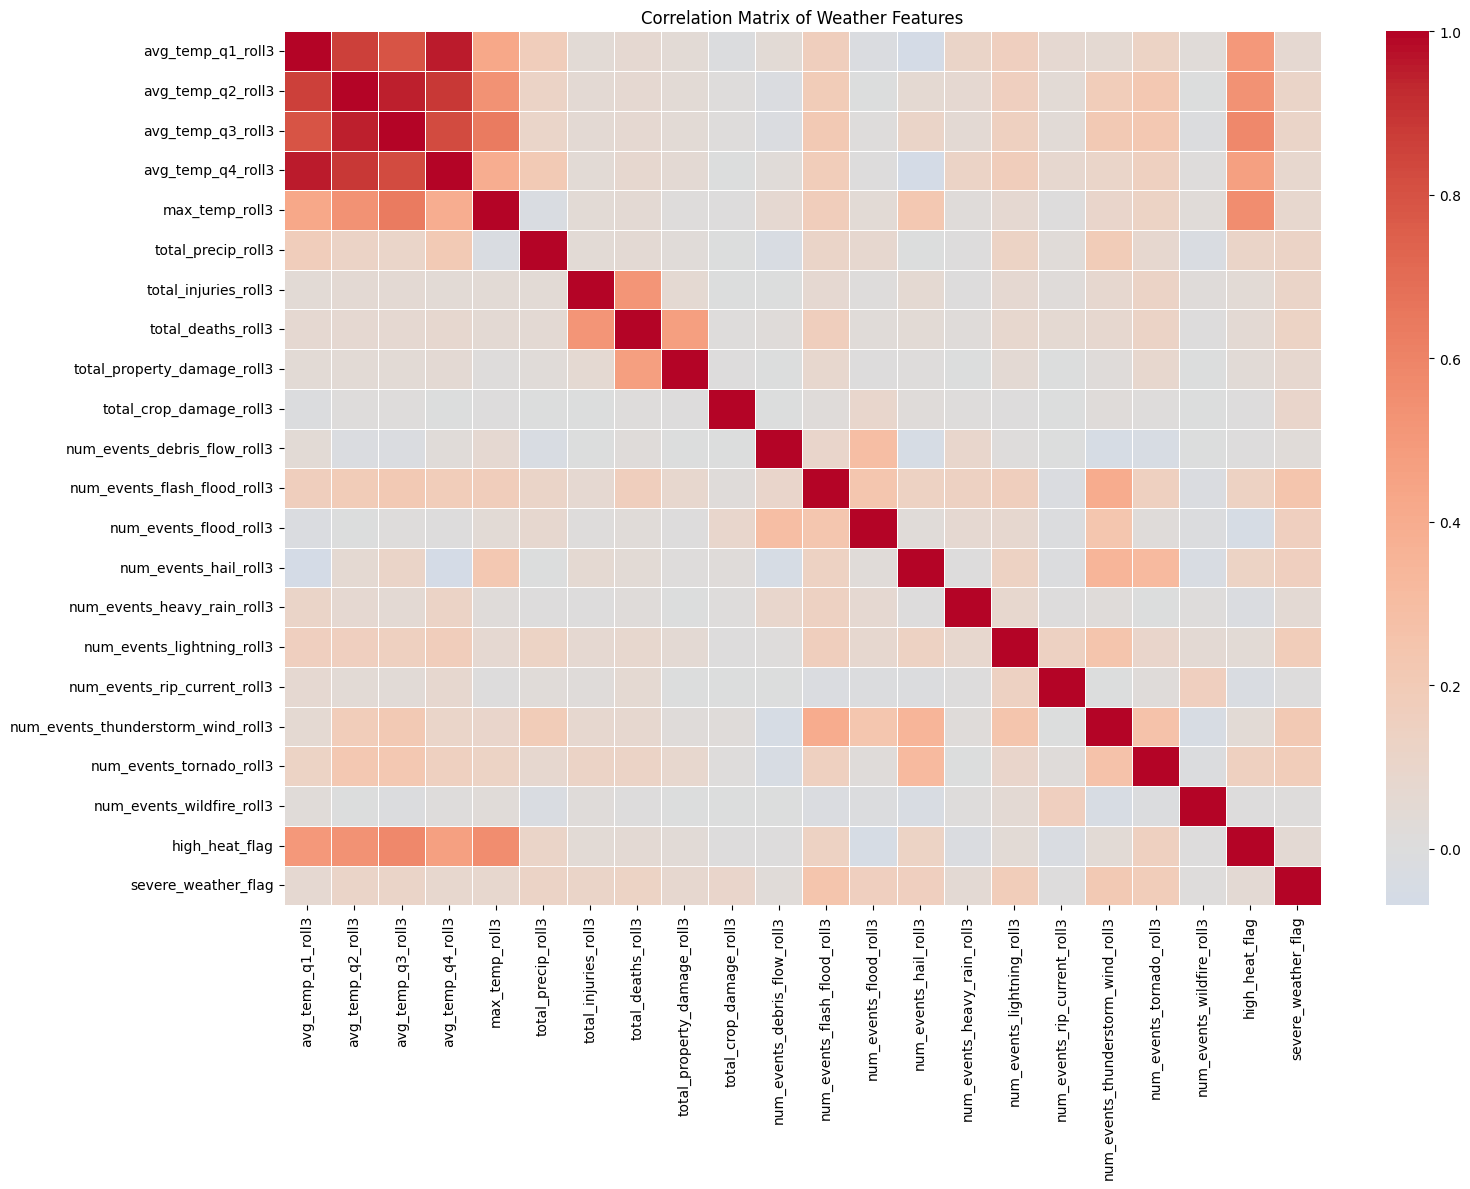

In [6]:
# # Select only numeric weather columns
# numeric_weather_cols = weather_clean.select_dtypes(include=["float64", "int64"]).columns

# Compute the correlation matrix
weather_corr = weather_numeric_scaled_df.corr()

# Plot the heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(weather_corr, annot=False, cmap='coolwarm', center=0, linewidths=0.5)
plt.title("Correlation Matrix of Weather Features")
plt.tight_layout()
plt.show()

### Variance Inflation Factor (VIF) Analysis

To quantify multicollinearity among the standardized weather features, we calculate the Variance Inflation Factor (VIF) for each variable.

- **Setup**: A constant term is added to the feature matrix using `statsmodels` to enable valid VIF computation.
- **Interpretation**:
  - VIF measures how much a feature is linearly explained by other features.
  - Higher values indicate greater redundancy.
- **Guideline**: Features with VIF > 5 may contribute to multicollinearity and are candidates for removal or dimensionality reduction.

This diagnostic helps refine the feature set before clustering and ensures more stable factor analysis results.


In [7]:
# # Select only numeric columns for VIF calculation (exclude identifiers and categorical fields)
# weather_numeric = weather_clean.select_dtypes(include=["float64", "int64"]).drop(columns=["year", "RUCC_2023"], errors="ignore")

# Add a constant for statsmodels VIF calculation
X = add_constant(weather_numeric_scaled_df)

# Compute VIF for each feature
vif_data = pd.DataFrame({
    "feature": X.columns,
    "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

# Drop the constant row for readability
vif_data = vif_data[vif_data["feature"] != "const"]

# Sort by highest VIF
vif_data = vif_data.sort_values(by="VIF", ascending=False)

print(vif_data)


                               feature        VIF
4                    avg_temp_q4_roll3  14.634864
2                    avg_temp_q2_roll3  14.499446
3                    avg_temp_q3_roll3  12.718495
1                    avg_temp_q1_roll3  12.109484
5                       max_temp_roll3   2.271349
8                   total_deaths_roll3   1.914613
21                      high_heat_flag   1.784606
18  num_events_thunderstorm_wind_roll3   1.590646
7                 total_injuries_roll3   1.480395
14               num_events_hail_roll3   1.379226
9          total_property_damage_roll3   1.377088
12        num_events_flash_flood_roll3   1.358927
13              num_events_flood_roll3   1.238325
19            num_events_tornado_roll3   1.227192
22                 severe_weather_flag   1.167514
16          num_events_lightning_roll3   1.161387
11        num_events_debris_flow_roll3   1.156036
6                   total_precip_roll3   1.146077
15         num_events_heavy_rain_roll3   1.062479


### Justification for Retaining High-VIF Temperature Features

Although the quarterly average temperature features show high multicollinearity (VIF > 10), we chose to retain them due to their critical role in capturing climate exposure and seasonal dynamics:

- These variables reflect **distinct seasonal heat patterns**, which are essential for identifying geographic variation in climate trends.
- Removing them would bias the dataset toward extreme events (e.g., heat days), reducing sensitivity to **baseline temperature variation** across regions and time.
- **Factor analysis** applied in later steps will reduce dimensionality and address redundancy while preserving key patterns in the data.

In this context, the **interpretive value and domain relevance** of seasonal temperature features outweigh the statistical risks posed by multicollinearity.


### Select Number of Factors via Scree Plot

To determine the optimal number of latent factors to retain, we fit a series of `FactorAnalysis` models using 1 to 20 components on the standardized weather feature set.

- **Model Evaluation**: For each factor count, we compute the model’s log-likelihood score—a proxy for how well the factor structure explains the observed data.
- **Scree Plot**: Log-likelihoods are plotted across different numbers of factors to identify the point of diminishing returns (the "elbow").
- **Interpretation**: The elbow point indicates where additional factors provide minimal gains in explanatory power, guiding a balanced selection of dimensionality.

This visual diagnostic helps preserve interpretability while capturing the most meaningful structure in the weather data.


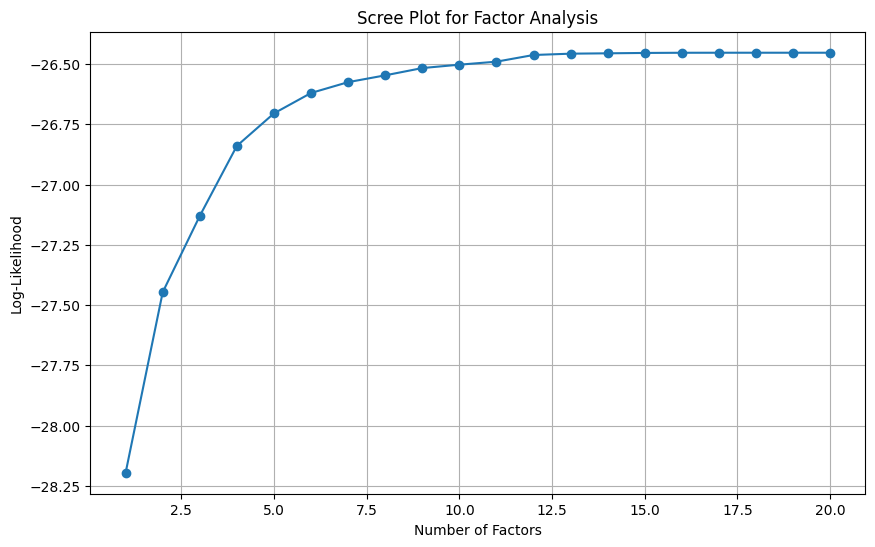

In [7]:
# Evaluate the variance explained across 1–20 factors
n_factors = list(range(1, 21))

fa_input = weather_numeric_scaled_df
fa_models = [FactorAnalysis(n_components=n, random_state=42, max_iter=3000).fit(fa_input) for n in n_factors]

# Extract log-likelihood values to compute approximate explained variance
log_likelihoods = [model.score(fa_input) for model in fa_models]

# Scree plot (based on log-likelihood gain, a proxy for information retained)
plt.figure(figsize=(10, 6))
plt.plot(n_factors, log_likelihoods, marker='o')
plt.title("Scree Plot for Factor Analysis")
plt.xlabel("Number of Factors")
plt.ylabel("Log-Likelihood")
plt.grid(True)
plt.show()

### Extract and Rotate Latent Weather Factors

After selecting the number of components, we extract latent factors from the standardized weather dataset using `FactorAnalyzer` and apply varimax rotation to improve interpretability.

- **Factor Extraction**: Seven latent factors are derived from the weather features, capturing shared structure and reducing dimensionality.
- **Varimax Rotation**: An orthogonal rotation method that redistributes feature weights, making each factor load strongly on a smaller, more distinct set of variables.
- **Loadings Matrix**: A rotated loadings matrix shows how strongly each original feature contributes to each factor.
- **Interpretation Aid**: For each factor, the top five features by absolute loading are displayed to help describe the underlying weather-driven patterns.

These rotated factors serve as compressed, interpretable summaries of the weather environment for each county and will form the input to downstream clustering.


In [8]:
# Initialize and fit the factor analyzer
fa = FactorAnalyzer(n_factors=7, rotation=None)
fa.fit(weather_numeric_scaled_df)

# Apply varimax rotation to the factor loadings
rotator = Rotator(method="varimax")
rotated_loadings = rotator.fit_transform(fa.loadings_)

fa_input = weather_numeric_scaled_df

# Create a DataFrame of the rotated loadings
rotated_df = pd.DataFrame(
    rotated_loadings,
    index=fa_input.columns,
    columns=[f"Factor{i+1}" for i in range(rotated_loadings.shape[1])]
)

# Display top 5 features per factor based on absolute loading
for i in range(rotated_df.shape[1]):
    print(f"\nTop loadings for Factor {i+1}:")
    display(rotated_df.iloc[:, i].abs().sort_values(ascending=False).head(5))


Top loadings for Factor 1:


avg_temp_q2_roll3    0.937715
avg_temp_q4_roll3    0.935196
avg_temp_q1_roll3    0.920987
avg_temp_q3_roll3    0.915569
high_heat_flag       0.595892
Name: Factor1, dtype: float64


Top loadings for Factor 2:


num_events_thunderstorm_wind_roll3    0.698404
num_events_hail_roll3                 0.574058
num_events_tornado_roll3              0.420895
num_events_flash_flood_roll3          0.392574
severe_weather_flag                   0.335341
Name: Factor2, dtype: float64


Top loadings for Factor 3:


total_injuries_roll3           0.980506
total_deaths_roll3             0.407555
num_events_tornado_roll3       0.059617
severe_weather_flag            0.058966
total_property_damage_roll3    0.042414
Name: Factor3, dtype: float64


Top loadings for Factor 4:


max_temp_roll3           0.585462
avg_temp_q4_roll3        0.289449
high_heat_flag           0.283943
total_precip_roll3       0.237522
num_events_hail_roll3    0.227402
Name: Factor4, dtype: float64


Top loadings for Factor 5:


num_events_flood_roll3                0.609651
num_events_debris_flow_roll3          0.465828
num_events_flash_flood_roll3          0.360444
severe_weather_flag                   0.196302
num_events_thunderstorm_wind_roll3    0.180370
Name: Factor5, dtype: float64


Top loadings for Factor 6:


total_deaths_roll3              0.726690
total_property_damage_roll3     0.658269
total_injuries_roll3            0.141313
num_events_flash_flood_roll3    0.104376
severe_weather_flag             0.087836
Name: Factor6, dtype: float64


Top loadings for Factor 7:


num_events_rip_current_roll3    0.474915
num_events_wildfire_roll3       0.305908
num_events_lightning_roll3      0.274765
avg_temp_q1_roll3               0.104408
avg_temp_q4_roll3               0.086120
Name: Factor7, dtype: float64

### Generate and Integrate County-Level Factor Scores

After extracting the seven latent weather factors, we calculate factor scores for each county to quantify how strongly it aligns with each underlying pattern.

- **Factor Scoring**: `FactorAnalysis` is used to project each county into the 7-factor space, producing a score for each latent dimension.
- **Descriptive Naming**: Each factor is assigned a meaningful name (e.g., `"seasonal_heat_load"`, `"convective_storm_activity"`) based on its top-loading features.
- **Metadata Table**: Factor names and descriptions are stored in a separate reference table to support interpretability in analysis and reporting.
- **Data Integration**: The factor scores are combined with the original scaled dataset to create `weather_df_with_scores`, providing both raw weather metrics and compressed latent summaries for each county.

This enriched dataset is now ready for clustering and downstream geographic or statistical analysis.


In [9]:
weather_factor_names = [
    "seasonal_heat_load",                 # Factor 1
    "convective_storm_activity",          # Factor 2
    "human_injury_and_fatality_risk",     # Factor 3
    "heat_and_precip_variability",        # Factor 4
    "hydrologic_event_risk",              # Factor 5
    "economic_impact_of_extreme_events",  # Factor 6
    "coastal_and_fire_event_risk"         # Factor 7
]

weather_factor_descriptions = [
    "Regions with consistently elevated seasonal temperatures and frequent extreme heat days",
    "Counties experiencing frequent convective storm activity, including hail, wind, and tornadoes",
    "Areas with a history of human injuries and fatalities from weather-related hazards",
    "Counties showing high variability in maximum temperatures and precipitation levels",
    "Flood-prone regions with high incidence of flash floods and debris flow events",
    "Locations with severe economic losses due to property damage and high-impact events",
    "Areas exposed to less common but severe hazards such as rip currents, wildfires, and lightning"
]

# Compute factor scores
weather_factor_scores = fa.transform(fa_input)
weather_factor_df = pd.DataFrame(
    weather_factor_scores,
    columns=weather_factor_names,
    index=fa_input.index
)

# descriptions as metadata
weather_factor_metadata = pd.DataFrame({
    "factor": weather_factor_names,
    "description": weather_factor_descriptions
})

# Merge factor scores back into the scaled weather DataFrame
weather_df_with_scores = pd.concat([weather_df_scaled.reset_index(drop=True), weather_factor_df], axis=1)

# Export the factor scores to CSV
weather_df_with_scores.to_csv("./data/weather_factor_scores.csv", index=False)

# Preview
print(weather_df_with_scores.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36019 entries, 0 to 36018
Data columns (total 35 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   geo_id                              36019 non-null  object 
 1   year                                36019 non-null  int64  
 2   county_name                         36019 non-null  object 
 3   State                               36019 non-null  object 
 4   county_geometry                     36019 non-null  object 
 5   RUCC_2023                           36019 non-null  int64  
 6   avg_temp_q1_roll3                   36019 non-null  float64
 7   avg_temp_q2_roll3                   36019 non-null  float64
 8   avg_temp_q3_roll3                   36019 non-null  float64
 9   avg_temp_q4_roll3                   36019 non-null  float64
 10  max_temp_roll3                      36019 non-null  float64
 11  total_precip_roll3                  36019

### Choose the Number of Clusters with Geographic Context

To determine the optimal number of clusters, we run K-Means using the 7 rotated weather factor scores as input features.

- **Cluster Evaluation**: For each value of `k` from 2 to 10:
  - **Inertia** is recorded to measure within-cluster compactness (lower is better).
  - **Silhouette Score** is computed to assess how well-separated the clusters are (higher is better).
- **Visualization**:
  - The **elbow plot** helps identify the point where increasing `k` yields diminishing returns in cluster compactness.
  - The **silhouette curve** provides insight into clustering quality across values of `k`.

Together, these metrics guide the selection of a cluster count that balances model simplicity, statistical performance, and geographic realism.


Silhouette Score for 2 clusters: 0.23471684476709626
Inertia for 2 clusters: 158933.19706955808
Silhouette Score for 3 clusters: 0.23486744972034385
Inertia for 3 clusters: 134681.61511351398
Silhouette Score for 4 clusters: 0.1917994695502737
Inertia for 4 clusters: 123232.7923199677
Silhouette Score for 5 clusters: 0.19350060542343003
Inertia for 5 clusters: 109929.6587702868
Silhouette Score for 6 clusters: 0.19801499674992445
Inertia for 6 clusters: 103358.13352773416
Silhouette Score for 7 clusters: 0.2103195904141804
Inertia for 7 clusters: 91643.68677797604
Silhouette Score for 8 clusters: 0.21533790916446238
Inertia for 8 clusters: 85044.8153167005
Silhouette Score for 9 clusters: 0.21981305131878448
Inertia for 9 clusters: 78481.45559126399
Silhouette Score for 10 clusters: 0.19365948684869594
Inertia for 10 clusters: 72954.65221431512


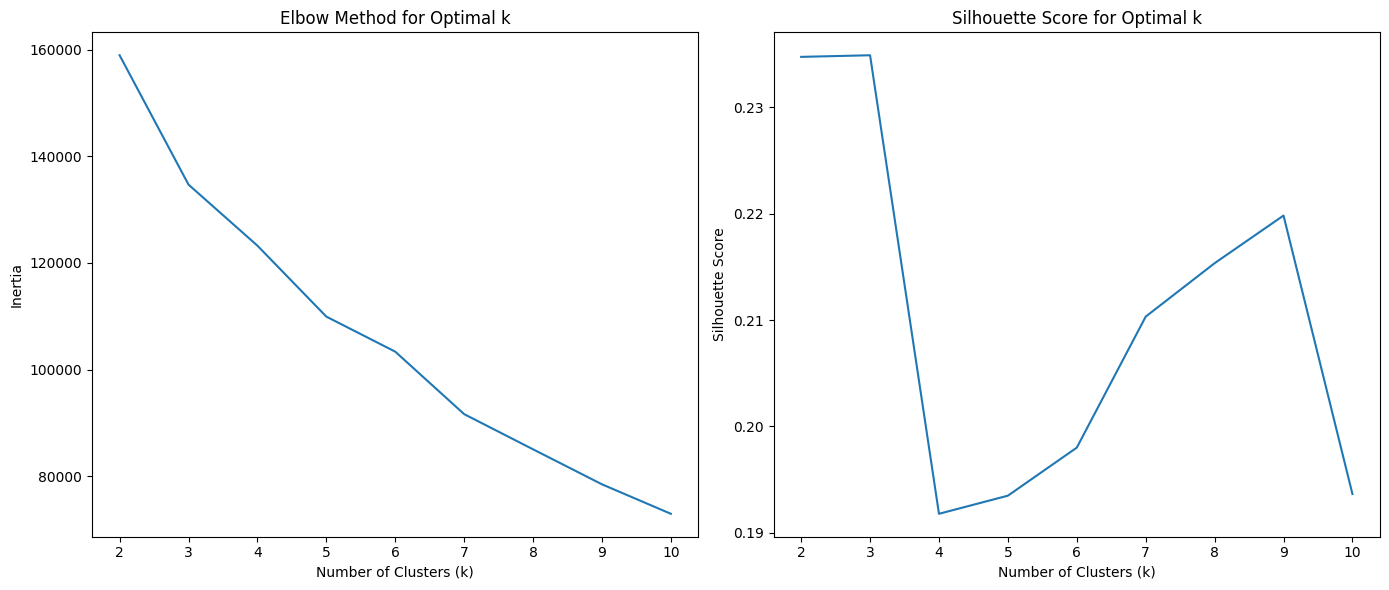

In [10]:
X = weather_df_with_scores[weather_factor_names].copy()

# 2. Initialize tracking lists
inertia = []
silhouette_scores = []
range_n_clusters = range(2, 11)

# 3. Run KMeans for k = 2 to 10
for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = kmeans.fit_predict(X)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, labels))
    print(f"Silhouette Score for {k} clusters: {silhouette_scores[-1]}")
    print(f"Inertia for {k} clusters: {inertia[-1]}")

# 4. Plot results
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Elbow plot
sns.lineplot(x=range_n_clusters, y=inertia, ax=axs[0])
axs[0].set_title("Elbow Method for Optimal k")
axs[0].set_xlabel("Number of Clusters (k)")
axs[0].set_ylabel("Inertia")

# Silhouette plot
sns.lineplot(x=range_n_clusters, y=silhouette_scores, ax=axs[1])
axs[1].set_title("Silhouette Score for Optimal k")
axs[1].set_xlabel("Number of Clusters (k)")
axs[1].set_ylabel("Silhouette Score")

plt.tight_layout()
plt.show()

### Final Cluster Assignment (k = 10)

Although initial testing suggested **k = 6** as a strong candidate, we selected **k = 10** for the final model to capture greater nuance in regional climate patterns and preserve distinct weather profiles.

- **Why k = 10**:
  - Provides better separation of **outlier counties** (e.g., rural extremes or localized hazard zones)
  - Allows retention of **subtle but meaningful differences** in exposure across climatic dimensions

- **Clustering Method**:
  - A `KMeans` model with `n_clusters=10` was trained on The 7 rotated weather factor scores
  - Each county was assigned to a cluster and labeled in a new `"weather_cluster"` column

- **Cluster Validation**:
  - Final cluster counts were checked to ensure balanced group sizes
  - While outlier clusters are present in the final selection with extremely small group sizing, the granularity afforded by a high K score was assessed to be worthwhile inspite of these outlier groups

While 10 clusters adds some complexity, it yielded the most interpretable and geographically consistent results. In subsequent steps, we will consolidate these into **higher-level macro clusters** to simplify interpretation without losing detail.


In [11]:
# Assign cluster labels to the DataFrame
optimal_k = 10 # Based on elbow method and silhouette score

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init="auto")
weather_df_with_scores["weather_cluster"] = kmeans.fit_predict(weather_df_with_scores[weather_factor_names])

print(weather_df_with_scores["weather_cluster"].value_counts())

weather_cluster
9    9924
4    8169
0    7530
3    5715
1    4337
5     211
8      71
6      50
2       9
7       3
Name: count, dtype: int64


### Merge Cluster Labels and Profile Group Traits

Cluster assignments and factor scores are merged back into the original dataset using `geo_id` and `year`, producing a labeled dataset (`labeled_county_df`) that includes both raw weather features and cluster membership.

- **Group Profiling**:  
  Each cluster is summarized by calculating the average value of all rotated weather factor scores using `.groupby("weather_cluster")`.  
  Results are rounded to two decimal places to improve readability and comparison.

This summary provides a high-level view of the defining characteristics of each cluster, supporting interpretation of weather risk patterns and regional climate segmentation across U.S. counties.


In [12]:
# Group by cluster label and compute mean values for each trait
weather_cluster_summary = weather_df_with_scores.groupby("weather_cluster")[weather_factor_names].mean().round(2)

# View the cluster profile summary
print(weather_cluster_summary)


                 seasonal_heat_load  convective_storm_activity  \
weather_cluster                                                  
0                              0.97                      -0.48   
1                              0.38                       1.04   
2                              4.27                      30.79   
3                              0.79                      -0.32   
4                             -0.84                       0.07   
5                              0.66                       1.48   
6                              1.32                       6.70   
7                              5.67                      27.28   
8                              1.19                       0.51   
9                             -0.70                      -0.07   

                 human_injury_and_fatality_risk  heat_and_precip_variability  \
weather_cluster                                                                
0                                         -0.36

### Final Dataset Labeling and Reordering

To prepare the weather clustering output for interpretation and reporting, we assigned descriptive names to each cluster and reorganized the dataset structure.

- **Cluster Labeling**: Each numeric cluster ID was mapped to a human-readable name (e.g., `"Storm-Prone Coastal and Fire-Risk Counties"`) and stored in a new column called `"weather_cluster_label"`.
- **Raw Feature Reintegration**: Raw 3-year rolling weather averages were merged back into the dataset. Standardized versions were dropped to avoid duplication.
- **Column Reordering**: The dataset was organized into a logical structure:
  - **Identifiers and metadata**: `geo_id`, `State`, `year`, `RUCC_2023`, `county_geometry`
  - **Clustering fields**: `weather_cluster` (ID) and `weather_cluster_label`
  - **Flags and factor scores**: e.g., `high_heat_flag` and latent dimensions
  - **Raw weather variables**: All 3-year rolling metrics used in scoring

The resulting dataset (`weather_df_labeled`) is now fully annotated, well-organized, and ready for use in visualizations, spatial analysis, and climate risk reporting.


In [13]:
# Identify standardized weather features already in weather_df_with_scores
standardized_cols_to_remove = [col for col in weather_df_with_scores.columns if col.endswith("_roll3")]

# Drop them before merge to avoid name collision
weather_df_cleaned = weather_df_with_scores.drop(columns=standardized_cols_to_remove + ["high_heat_flag"], errors="ignore")

raw_weather_vars = [col for col in weather_clean.columns if col.endswith("_roll3")]

# Now merge raw data back in
weather_df_labeled = weather_df_cleaned.merge(
    weather_clean[["geo_id", "year", "high_heat_flag"] + raw_weather_vars],
    on=["geo_id", "year"],
    how="left"
)

cluster_names = {
    0:	"Seasonally Warm Counties with Moderate Conditions",
    1:	"Moderate Heat with Elevated Human Weather Impact",
    2:	"Severe Storm and Damage Outlier Cluster",
    3:	"Mild Weather Counties with Slight Hydrologic Risk",
    4:	"Cooler Areas with Slight Precipitation Extremes",
    5:	"Lightning- and Storm-Exposed Zones with Moderate Heat",
    6:	"Warm, Variable Regions with Moderate Economic Losses",
    7:	"Extreme Heat and Flood-Prone Outlier Cluster",
    8:	"Storm-Prone Coastal and Fire-Risk Counties",
    9:	"Low-Risk Mild Climate Counties"
}

weather_df_labeled["weather_cluster_label"] = weather_df_labeled["weather_cluster"].map(cluster_names)

# Reorder for clarity
weather_final_columns = [
    "geo_id", "county_name", "State", "year", "RUCC_2023", "county_geometry",
    "weather_cluster", "weather_cluster_label", "high_heat_flag"
] + weather_factor_names + raw_weather_vars

# Apply column order
weather_df_labeled = weather_df_labeled[weather_final_columns]

# Preview
weather_df_labeled.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36019 entries, 0 to 36018
Data columns (total 36 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   geo_id                              36019 non-null  object 
 1   county_name                         36019 non-null  object 
 2   State                               36019 non-null  object 
 3   year                                36019 non-null  int64  
 4   RUCC_2023                           36019 non-null  int64  
 5   county_geometry                     36019 non-null  object 
 6   weather_cluster                     36019 non-null  int32  
 7   weather_cluster_label               36019 non-null  object 
 8   high_heat_flag                      36019 non-null  int64  
 9   seasonal_heat_load                  36019 non-null  float64
 10  convective_storm_activity           36019 non-null  float64
 11  human_injury_and_fatality_risk      36019

### Macro-Cluster Grouping and Visualization

To simplify interpretation and highlight broad spatial patterns, the 10 detailed weather clusters were consolidated into four higher-level **macro-clusters** based on shared climate exposure and risk traits:

- **Extreme Weather Impact**: Counties facing high-impact events like severe storms, flooding, and extreme heat.
- **Elevated Weather Exposure**: Regions with recurring storm activity, lightning, and moderate heat risk.
- **Moderate Impact Regions**: Areas with mixed weather patterns and mild-to-moderate risk factors.
- **Low Risk Zones**: Counties with stable, mild climate conditions and minimal extreme weather indicators.

- A new column, `"macro_cluster"`, was added by mapping cluster labels to their corresponding group.
- The dataset was converted to a `GeoDataFrame`, and each macro-cluster was assigned a distinct color.
- A choropleth map was generated to show the spatial distribution of macro-clusters across U.S. counties, with a clear legend and thematic color palette.

This visualization supports communication of regional weather risk trends while preserving the insights gained from detailed factor-based clustering.


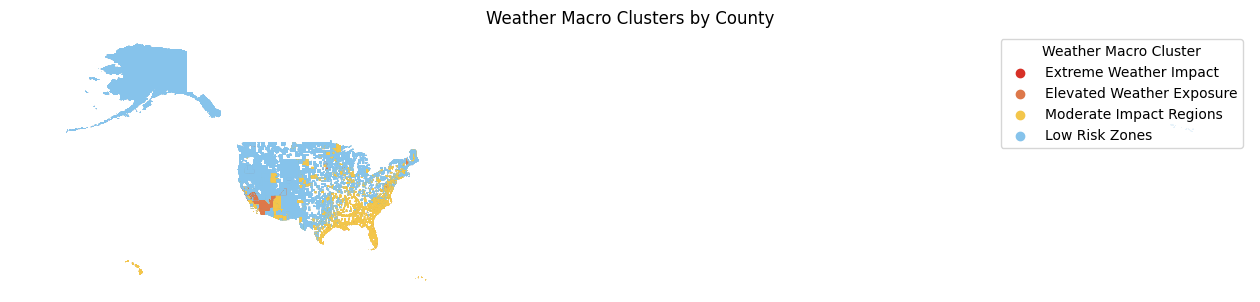

In [14]:
# Define macro cluster groupings
macro_cluster_map = {
    "Severe Storm and Damage Outlier Cluster": "Extreme Weather Impact",
    "Extreme Heat and Flood-Prone Outlier Cluster": "Extreme Weather Impact",
    "Storm-Prone Coastal and Fire-Risk Counties": "Elevated Weather Exposure",
    "Lightning- and Storm-Exposed Zones with Moderate Heat": "Elevated Weather Exposure",
    "Warm, Variable Regions with Moderate Economic Losses": "Moderate Impact Regions",
    "Moderate Heat with Elevated Human Weather Impact": "Moderate Impact Regions",
    "Seasonally Warm Counties with Moderate Conditions": "Moderate Impact Regions",
    "Mild Weather Counties with Slight Hydrologic Risk": "Low Risk Zones",
    "Cooler Areas with Slight Precipitation Extremes": "Low Risk Zones",
    "Low-Risk Mild Climate Counties": "Low Risk Zones"
}

# Map macro clusters
weather_df_labeled["macro_cluster"] = weather_df_labeled["weather_cluster_label"].map(macro_cluster_map)

# Define macro cluster color mapping
macro_cluster_colors = {
    "Extreme Weather Impact": "#d73027",
    "Elevated Weather Exposure": "#dd784a",
    "Moderate Impact Regions": "#f3c64b",
    "Low Risk Zones": "#86c3eb"
}

# Rebuild GeoDataFrame if necessary
gdf = gpd.GeoDataFrame(
    weather_df_labeled,
    geometry=gpd.GeoSeries.from_wkt(weather_df_labeled["county_geometry"]),
    crs="EPSG:4326"
)

# Add color for macro clusters
gdf["color"] = gdf["macro_cluster"].map(macro_cluster_colors)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
gdf.plot(color=gdf["color"], ax=ax)

# Manual legend
for label, color in macro_cluster_colors.items():
    ax.scatter([], [], color=color, label=label)
ax.legend(title="Weather Macro Cluster", loc="upper right")

ax.set_title("Weather Macro Clusters by County")
ax.set_axis_off()
plt.show()


### Full U.S. Map with Alaska and Hawaii Insets

To provide a complete national view of the weather macro-clusters, we created a choropleth map that includes all U.S. counties, with insets for Alaska and Hawaii:

- **Main Map**: Displays the 48 contiguous states, color-coded by macro-cluster.
- **Inset Panels**:
  - **Alaska** is shown in a lower inset with adjusted axis limits and positioning for visibility.
  - **Hawaii** appears in a separate inset for clarity and geographic accuracy.
- **Legend**: A custom legend maps macro-cluster labels to colors, aiding interpretation of regional climate patterns.

This layout ensures full spatial coverage while maintaining visual clarity and coherence across all regions of the United States.


C:\Users\iauge\AppData\Local\Temp\ipykernel_21320\3946459023.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


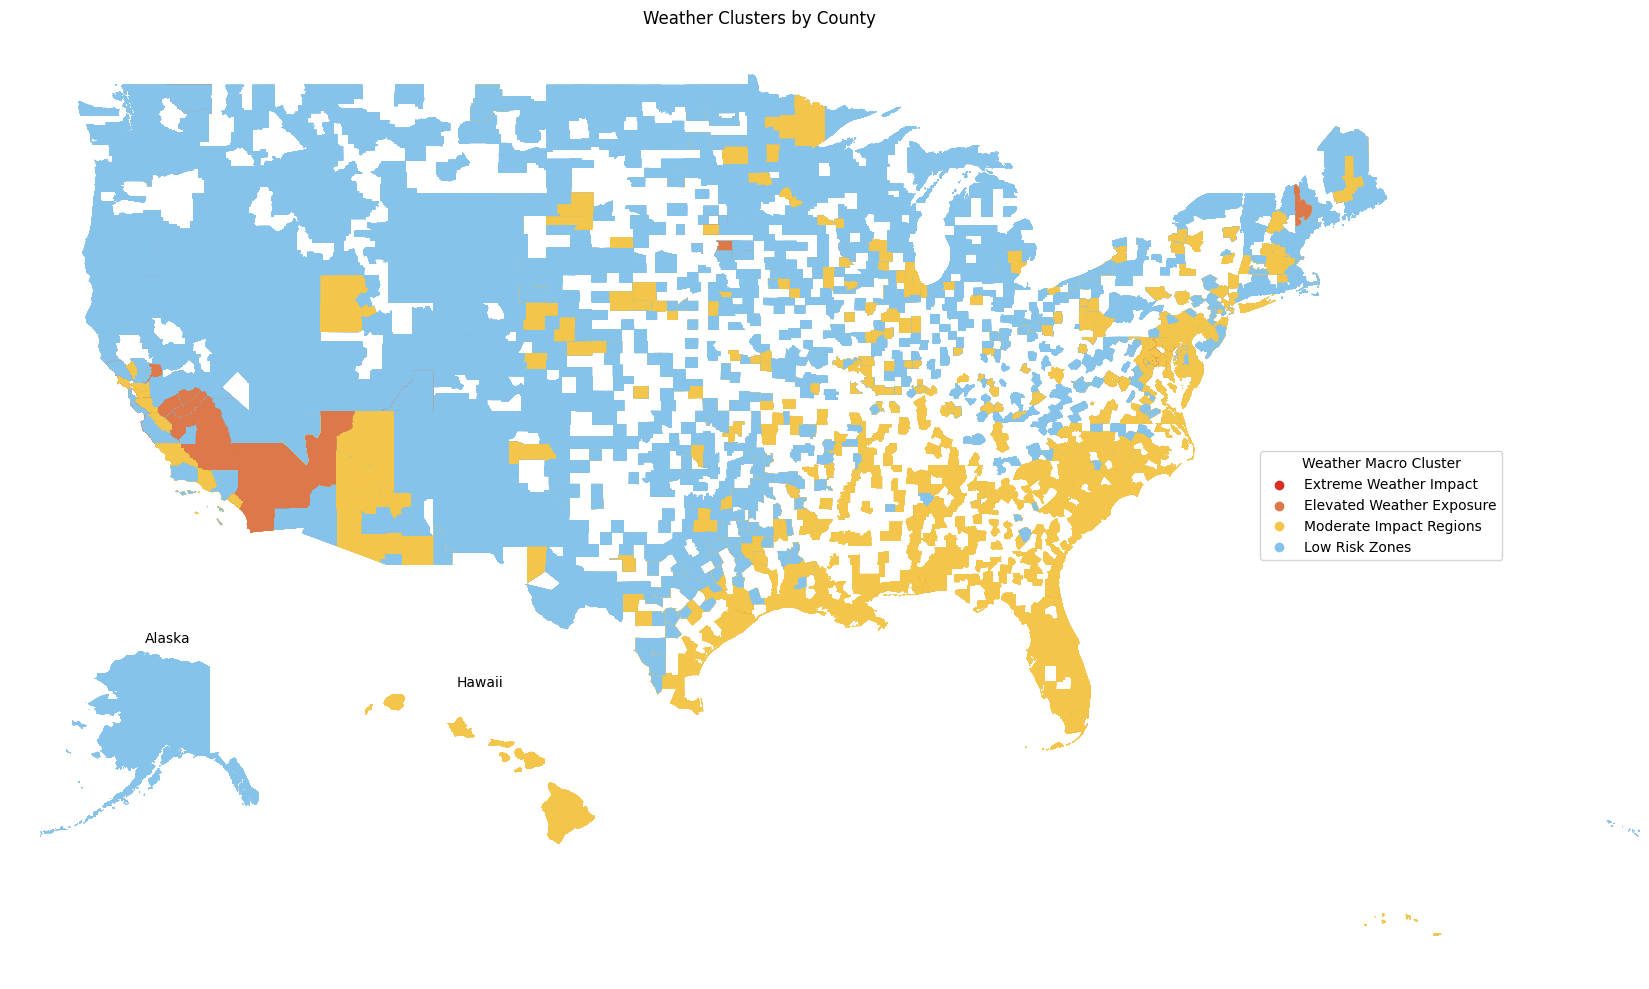

In [18]:
# Split by state
contiguous = gdf[~gdf["State"].isin(["AK", "HI"])]
alaska = gdf[gdf["State"] == "AK"]
hawaii = gdf[gdf["State"] == "HI"]

# Create main figure
fig, ax = plt.subplots(figsize=(16, 10))
contiguous.plot(color=contiguous["color"], ax=ax)
ax.set_title("Weather Clusters by County")
ax.set_axis_off()

# --- Alaska Inset ---
ax_ak = fig.add_axes([0.05, -0.25, 1, 1])  # [x, y, width, height]
alaska.plot(color=alaska["color"], ax=ax_ak)
ax_ak.set_title("Alaska", fontsize=10, position=(0.08, 1.05))  # Adjust title position
ax_ak.set_axis_off()
ax_ak.set_xlim(*alaska.total_bounds[[0, 2]])
ax_ak.set_ylim(*alaska.total_bounds[[1, 3]])

# --- Hawaii Inset ---
ax_hi = fig.add_axes([0.25, 0.15, 0.15, 0.15])
hawaii.plot(color=hawaii["color"], ax=ax_hi)
ax_hi.set_title("Hawaii", fontsize=10, position=(0.5, 1.05))
ax_hi.set_axis_off()
ax_hi.set_xlim(*hawaii.total_bounds[[0, 2]])
ax_hi.set_ylim(*hawaii.total_bounds[[1, 3]])

# --- Legend ---
for label, color in macro_cluster_colors.items():
    ax.scatter([], [], color=color, label=label)
ax.legend(title="Weather Macro Cluster", loc="right")

plt.tight_layout()
plt.show()

In [41]:
weather_df_labeled.to_csv("./data/weather_clusters.csv", index=False)

## Summary: County-Level Weather Risk Clusters

The final model segments U.S. counties into 10 distinct clusters based on weather patterns, hazard exposure, and geographic context. These clusters are then consolidated into four macro-cluster groups:

- **Extreme Weather Impact**: Regions with intense storm, flood, or heat exposure and high economic consequences
- **Elevated Weather Exposure**: Counties with frequent severe weather but moderate impacts
- **Moderate Impact Regions**: Areas with mixed weather risks and relatively stable climate behavior
- **Low Risk Zones**: Counties with consistently mild and stable weather patterns

These groups are visualized in a full U.S. map with insets for Alaska and Hawaii, providing a clear, accessible view of spatial weather risk distribution. The final dataset (`weather_df_labeled`) is structured for use in further statistical analysis, policy planning, or integrated risk modeling.
